# Creating the network

Creating the network .gml file from the column given

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import ast

In [2]:
df_zip = pd.read_csv("../zipcode_by_state.csv")
df_zip["Zip Min"].astype(int)
df_zip["Zip Min"].astype(int)
df_zip.head()

,ID,State Name,ST,Zip Min,Zip Max
0,44,Puerto Rico,PR,0,0
1,26,Massachusetts,MA,1001,2791
2,45,Rhode Island,RI,2801,2940
3,34,New Hampshire,NH,3031,3897
4,24,Maine,ME,3901,4992


In [3]:
df_postings = pd.read_csv("../data/postings.csv")

In [4]:
filtered_columns  = ['job_id', 'company_name', 'description', 'skills_desc', 'zip_code', 'normalized_salary']
df_postings_shortened = df_postings[filtered_columns].head(100)
df_postings_shortened.head()

,job_id,company_name,description,skills_desc,zip_code,normalized_salary
0,921716,Corcoran Sawyer Smith,Job descriptionA leading real estate firm in N...,Requirements: \n\nWe are seeking a College or ...,8540.0,38480.0
1,1829192,NaN,"At Aspen Therapy and Wellness , we are committ...",NaN,80521.0,83200.0
2,10998357,The National Exemplar,The National Exemplar is accepting application...,We are currently accepting resumes for FOH - A...,45202.0,55000.0
3,23221523,"Abrams Fensterman, LLP",Senior Associate Attorney - Elder Law / Trusts...,This position requires a baseline understandin...,11040.0,157500.0
4,35982263,NaN,Looking for HVAC service tech with experience ...,NaN,52601.0,70000.0


# Adding industry information

In [5]:
# Read the job_industry csv
df_industries_list = pd.read_csv("../data/mappings/industries.csv")
df_industries_list.head()

,industry_id,industry_name
0,1,Defense and Space Manufacturing
1,3,Computer Hardware Manufacturing
2,4,Software Development
3,5,Computer Networking Products
4,6,"Technology, Information and Internet"


In [6]:
# Read the industry id file
df_job_industries_match = pd.read_csv("../data/jobs/job_industries.csv")
df_job_industries_match.head()

,job_id,industry_id
0,3884428798,82
1,3887473071,48
2,3887465684,41
3,3887467939,82
4,3887467939,80


In [7]:
df_job_industry_name_match = pd.merge(df_industries_list, df_job_industries_match, on='industry_id', how='inner') 
df_job_industry_name_match.head()

,industry_id,industry_name,job_id
0,1,Defense and Space Manufacturing,3887470617
1,1,Defense and Space Manufacturing,3887475133
2,1,Defense and Space Manufacturing,3884916275
3,1,Defense and Space Manufacturing,3884436032
4,1,Defense and Space Manufacturing,3887489518


In [8]:
df_postings_shortened = pd.merge(df_job_industry_name_match, df_postings_shortened, on='job_id', how='inner') 
df_postings_shortened.head()

,industry_id,industry_name,job_id,company_name,description,skills_desc,zip_code,normalized_salary
0,4,Software Development,1014822088,Tracker,About TrackerTracker is a leading global cloud...,NaN,NaN,75000.0
1,6,"Technology, Information and Internet",175485704,GOYT,Job Description:GOYT is seeking a skilled and ...,NaN,80202.0,NaN
2,8,Telecommunications,857299959,NaN,"Business Telecommunications, Managed Networks ...",NaN,7601.0,65000.0
3,9,Law Practice,935210241,Einbinder & Dunn LLP,"Growing, boutique law firm seeks a transaction...",NaN,10001.0,NaN
4,9,Law Practice,2314566469,Diment & Associates,Regional law firm looking for a candidate with...,NaN,70801.0,NaN


# Adding state information

In [9]:
def assign_state(zipcode):
    # Find the range that the zipcode falls into
    state_row = df_zip[(df_zip['Zip Min'] <= zipcode)]
    
    # Return the state if a match is found, otherwise return None
    if not state_row.empty:
        return state_row['ST'].iloc[-1]
    else:
        return None

In [10]:
assign_state(1500)

'MA'

In [58]:
df_postings_shortened['state'] = df_postings_shortened['zip_code'].apply(assign_state)
df_postings_shortened.head()

,industry_id,industry_name,job_id,company_name,description,skills_desc,zip_code,normalized_salary,state
0,4,Software Development,1014822088,Tracker,About TrackerTracker is a leading global cloud...,NaN,NaN,75000.0,None
1,6,"Technology, Information and Internet",175485704,GOYT,Job Description:GOYT is seeking a skilled and ...,NaN,80202.0,NaN,CO
2,8,Telecommunications,857299959,NaN,"Business Telecommunications, Managed Networks ...",NaN,7601.0,65000.0,NJ
3,9,Law Practice,935210241,Einbinder & Dunn LLP,"Growing, boutique law firm seeks a transaction...",NaN,10001.0,NaN,NY
4,9,Law Practice,2314566469,Diment & Associates,Regional law firm looking for a candidate with...,NaN,70801.0,NaN,LA


In [59]:
all_states = df_postings_shortened["state"].unique()

In [60]:
# Creating a network graph
G = nx.Graph()

for state in all_states:
    state_row = df_postings_shortened[df_postings_shortened["state"] == state]
    # Add nodes and edges for every combination of skills in the list
    for job1, job2 in combinations(state_row['job_id'], 2):
        G.add_edge(job1, job2, weight=1)

In [62]:
# Convert DataFrame to dictionary with job_id as key
attrs = {
    row['job_id']: {
        'state': row['state'],
        'normalized_salary': row['normalized_salary'],
        'industry_name': row['industry_name']
    }
    for _, row in df_postings_shortened.iterrows()
}

attrs

{1014822088: {'state': None,
  'normalized_salary': 75000.0,
  'industry_name': 'Software Development'},
 175485704: {'state': 'CO',
  'normalized_salary': nan,
  'industry_name': 'Technology, Information and Internet'},
 857299959: {'state': 'NJ',
  'normalized_salary': 65000.0,
  'industry_name': 'Telecommunications'},
 935210241: {'state': 'NY',
  'normalized_salary': nan,
  'industry_name': 'Law Practice'},
 2314566469: {'state': 'LA',
  'normalized_salary': nan,
  'industry_name': 'Law Practice'},
 23221523: {'state': 'NY',
  'normalized_salary': 157500.0,
  'industry_name': 'Law Practice'},
 136743465: {'state': 'FL',
  'normalized_salary': nan,
  'industry_name': 'Law Practice'},
 2234533717: {'state': None,
  'normalized_salary': nan,
  'industry_name': 'Business Consulting and Services'},
 2558399667: {'state': 'CA',
  'normalized_salary': 135200.0,
  'industry_name': 'Medical Equipment Manufacturing'},
 117675818: {'state': 'GA',
  'normalized_salary': nan,
  'industry_name':

In [63]:
# Add attributes to nodes in graph
nx.set_node_attributes(G, attrs)

In [64]:
# Export the graph to a GML file
nx.write_gml(G, '../graphs/location_graph.gml')

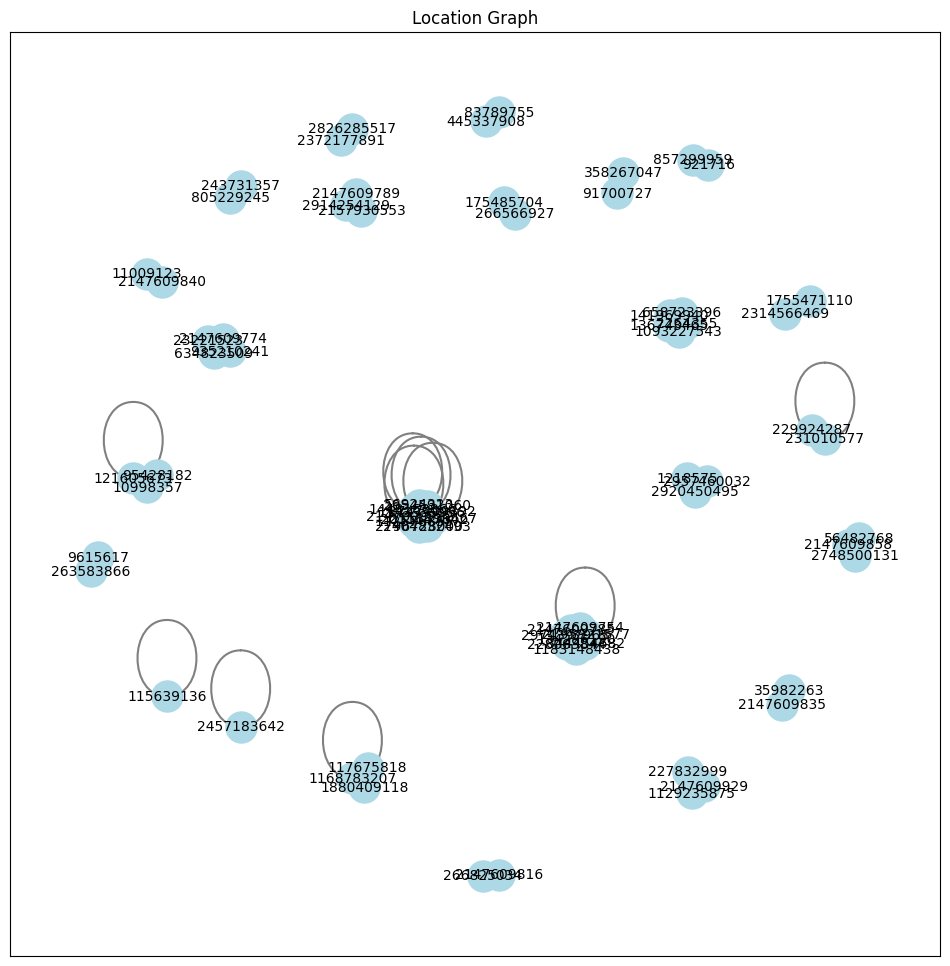

In [66]:
# Read the GML File and plot the graph
plt.figure(figsize=(12, 12))  # Set the figure size

# Draw the graph with a spring layout (which tries to position nodes in a visually pleasing way)
pos = nx.spring_layout(G)

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')

# Draw the edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=1.5, edge_color='gray')

# Draw the labels for each node
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Display the plot
plt.title("Location Graph")
plt.show()

# Average Degree

In [37]:
# Printing the useful information of the graphs
G = G.to_undirected()

# Average degree
degrees = []
for node, deg in G.degree():
    degrees.append(deg)
average_degree = sum(degrees) / len(degrees)
print(f"Average degree of the graph: {average_degree}")

Average degree of the graph: 4.0


# Clustering Coefficient
### Average clustering coefficient
<What does the average clustering coefficient represent? >

### Global clustering coefficient
<What does the average clustering coefficient represent? >

In [38]:
# 1. Average clustering coefficient
avg_clustering = nx.average_clustering(G)
print(f"Average Clustering Coefficient: {avg_clustering}")

# 2. Global clustering coefficient (Transitivity)
global_clustering = nx.transitivity(G)
print(f"Global Clustering Coefficient (Transitivity): {global_clustering}")

Average Clustering Coefficient: 0.7297297297297297
Global Clustering Coefficient (Transitivity): 1.0


# Nodes with highest degree

In [39]:
# Getting the most connected nodes

nodes_with_degrees = G.degree()

sorted_nodes = sorted(nodes_with_degrees, key=lambda x: x[1], reverse=True)

# Get the top 10 nodes with the highest degree
top_10_nodes = sorted_nodes[:10]

# Print the result
for node, degree in top_10_nodes:
    print(f"Node: {node}, Degree: {degree}")

Node: 112576855, Degree: 11
Node: 56924323, Degree: 11
Node: 1143359956, Degree: 11
Node: 1448163866, Degree: 11
Node: 2011147642, Degree: 11
Node: 2147609712, Degree: 11
Node: 2404832493, Degree: 11
Node: 2558399667, Degree: 11
Node: 2737009242, Degree: 11
Node: 2747409392, Degree: 11


# Plotting the graphs

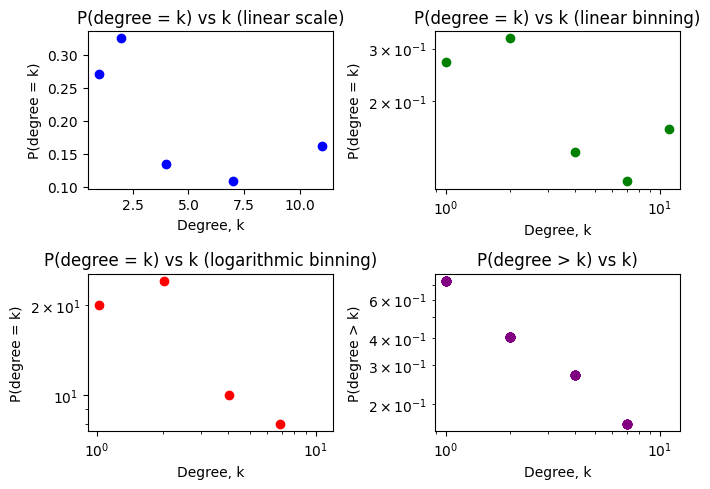

In [40]:
k_values, P_k = np.unique(degrees, return_counts=True)
P_k = P_k / sum(P_k)

# Creating subplot for the four different plots
fig, axs = plt.subplots(2, 2, figsize=(7, 5))

# === 1. P(degree = k) as a function of k in linear scale ===
# This is equivalent to just plotting the graphs
axs[0, 0].scatter(k_values, P_k, color='blue')
axs[0, 0].set_xlabel('Degree, k')
axs[0, 0].set_ylabel('P(degree = k)')
axs[0, 0].set_title('P(degree = k) vs k (linear scale)')

# === 2. P(degree = k) in a log-log scale with linear binning
axs[0, 1].scatter(k_values, P_k, color='green')
# Allows me to log the x and the y graphs
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
axs[0, 1].set_xlabel('Degree, k')
axs[0, 1].set_ylabel('P(degree = k)')
axs[0, 1].set_title('P(degree = k) vs k (linear binning)')

# === 3. P(degree = k) in a log-log scale with log binning (x-axis)

# Creating bins on a logarithmic scale.
# This means that the width of the spaces increases
k_bins = np.logspace(np.log10(min(k_values)), np.log10(max(k_values)))
# hist: Counts the degrees within each bin
# bin_edges: Boundaries of each bin, so we only want to plot the middle point
hist, bin_edges = np.histogram(degrees, bins=k_bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

axs[1, 0].scatter(bin_centers, hist, color='red')
# Allows me to log the x and the y graphs
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
axs[1, 0].set_xlabel('Degree, k')
axs[1, 0].set_ylabel('P(degree = k)')
axs[1, 0].set_title('P(degree = k) vs k (logarithmic binning)')

# === 4. P(degree = k) in a log-log scale with log binning (x-axis)
# Sort degrees in descending order
sorted_degrees = np.sort(degrees)[::-1]
# Calculate the CCDF: P(degree > k) for each degree
# np.sum(sorted_degrees > k) is the CCDF.
ccdf = np.array([np.sum(sorted_degrees > k)
                for k in sorted_degrees]) / len(degrees)

# Plot the CCDF
axs[1, 1].scatter(sorted_degrees, ccdf, color='purple')
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlabel('Degree, k')
axs[1, 1].set_ylabel('P(degree > k)')
axs[1, 1].set_title('P(degree > k) vs k)')

plt.tight_layout()
plt.show()
